## Introducción

### Clasificación de tumores renales sólidos a partir de tomografía computada con contraste usando características radiómicas y Machine Learning

El diagnóstico diferencial tanto por tomografía como por resonancia magnética entre un carcinoma de células claras (maligno) versus un oncocitoma (benigno), le impone al médico radiólogo un desafío cuando se encuentra evaluado una lesión renal.  Informar un oncocitoma renal sugiere el control evolutivo de la lesión renal mientras que informar un carcinoma renal sugiere una nefrectomía (parcial o total). 

El método diagnóstico que permite confirmar el tipo de lesión es la anatomía patológica post quirúrgica de la resección. Actualmente, la práctica clínica es practicar la nefrectomía ya que no se puede descartar con certeza la malignidad de la lesión. Sin embargo, en pacientes con múltiples lesiones, funcionalidad renal disminuida, o monorrenos, la decisión terapéutica es compleja y riesgosa. Sería de gran utilidad contar con una herramienta que pueda calcular la probabilidad de malignidad para asistir en la toma de decisiones del diagnóstico.

La problemática motivó un estudio llevado a cabo en el Hospital Italiano de Buenos Aires entre el Servicio de Diagnóstico por Imágenes, el Servicio de Urología y el Departamento de Informática en Salud. En este estudio se recolectó de forma retrospectiva un dataset incluyendo pacientes con lesiones renales operados en la institución, que contaran con un resultado de anatomía patológica informando el estándar de referencia sobre el subtipo tumoral. El estudio de tomografía computada con contraste utilizado para evaluar estas lesiones tiene cuatro fases: sin contraste, nefrográfica, corticomedular y excretora. Se recolectaron las imágenes locales prequirúrgicas y se realizó una segmentación manual volumétrica del tumor en la fase que presentase límite más claros. Se calculó para cada lesión sus características radiómicas, que son un conjunto de variables cuantitativas que describen la distribución de niveles de gris, la textura, y la forma de la lesión. 
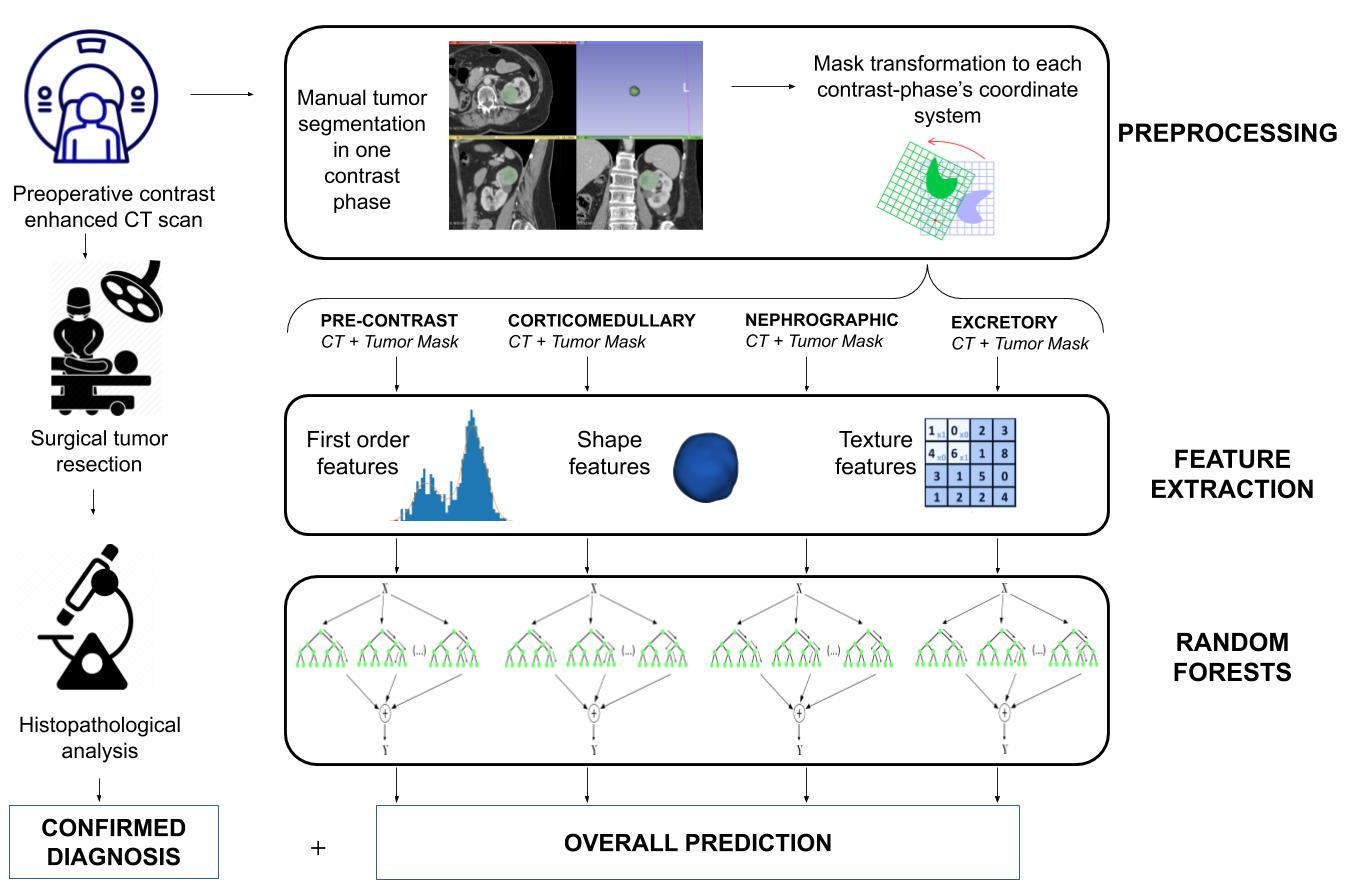




En este trabajo, utilizamos este dataset para desarrollar un método de clasificación de lesiones renales. La variable de salida es el tipo de tumor (carcinoma u oncocitoma), y las variables de entrada son las características radiómicas de la lesión en fase nefrográfica de la tomografía computada con contraste. 

## Pasos iniciales

### Imports

In [1]:
import pickle, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import cv2
from scipy import stats

from google.colab import drive

drive.mount('/content/drive')
drive_dir = '/content/drive/My Drive/Uro2021/'

Mounted at /content/drive


In [2]:
!pip install scikit-learn==0.24

     |████████████████████████████████| 22.3 MB 1.6 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, LeaveOneOut as LOOCV
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression as LR
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.svm import SVC,LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, roc_auc_score, precision_recall_curve,brier_score_loss
from sklearn.metrics import auc as sklearnAUC

### Definir funciones

In [4]:
def correlationFeatureByImageTypes(features_df,feature_name, imageTypes):
  cols = [f"{imageType}_{feature_name}" for imageType in imageTypes]
  feature_vals = features_df[cols] #if f"{imageType}_{feature_name}" in features_df.columns]]
  feature_vals.columns = imageTypes
  feature_vals['class'] = features_df['class'].copy()

  corrMatrix = feature_vals.corr()
  fig = sns.pairplot(feature_vals, hue='class',corner=True,plot_kws=dict(marker="+", linewidth=1))

  return fig, corrMatrix

In [5]:
def boxPlot(feature_df,feature_names):
  new_df = pd.DataFrame(columns=['class','feature','value'])
  for i,row in feature_df.iterrows():
    
    for feat in feature_names:
      newrow = {}
      newrow['feature'] = feat.split('_')[-1]
      newrow['value'] = row[feat]
      newrow['class'] = row['class']      
      new_df = new_df.append(newrow,ignore_index=True)
  g = sns.FacetGrid(new_df, col="feature", sharey=False)
  g.map(sns.boxplot, 'class', 'value')  
  #sns.boxplot(x="value", y="feature", data=new_df,hue='class',
  #          whis=[0, 100], width=.6, palette="vlag")

In [6]:
def getClassificationMetrics(preds, labels_test, print_results=True,cont_preds=None):
    if cont_preds is None:
        cont_preds = preds.copy()
    try:
        fpr, tpr, th = roc_curve(labels_test, cont_preds)
        aucroc = roc_auc_score(labels_test, cont_preds)
        print('AUCROC: {:.3f}'.format(aucroc))
    except Exception as e:
        print('couldnt calculate roc curve because error: {}'.format(e))
        aucroc = np.nan

    try:
        precision, recall, thresholds = precision_recall_curve(labels_test, cont_preds)
        aucpr = sklearnAUC(recall, precision)
        print('AUCPR: {:.3f}'.format(aucpr))
    except Exception as e:
        print('couldnt calculate PR curve because error: {}'.format(e))
        aucpr = np.nan
    c = confusion_matrix(labels_test, preds).ravel()
    print('Confusion matrix: ',c)
    (tn, fp, fn, tp ) = c
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)
    ppv = tp / (tp + fp)
    npv = tn / (tn + fn)
    acc = (tp + tn) / (tn + fp + fn + tp)
    f1score = 2 * ppv * sens / (ppv + sens)

    #TODO agregar brier score + y -
    positive_labels = labels_test[labels_test == 1]
    Npos = len(positive_labels)
    positive_preds = cont_preds[labels_test == 1]

    negative_labels = labels_test[labels_test == 0]
    negative_preds = cont_preds[labels_test == 0]

    assert len(positive_labels) + len(negative_labels) == len(labels_test)

    brierPos = brier_score_loss(positive_labels, positive_preds)
    brierNeg = brier_score_loss(negative_labels, negative_preds)
    brier = brier_score_loss(labels_test, preds)

    if print_results:
        print(f'True negatives:{tn}\nTrue positives:{tp}\nFalse negatives:{fn}\nFalse positives:{fp}')
        print(f'\nSensitivity(recall):{sens:.2f}\nSpecificity:{spec:.2f}')
        print(f'PPV(precision):{ppv:.2f}\nNPV:{npv:.2f}\n')

        print('f1-score:{:.3f}'.format(f1score))
        print('accuracy:{:.3f}'.format(acc))
        print('brier {:.3f}. brier+ {:.3f}. brier- {:.3f}'.format(brier,brierPos,brierNeg))

    return (tn, fp, fn, tp), (sens, spec, ppv, npv), (acc, f1score, aucroc,aucpr), (brier,brierPos,brierNeg)

### Cargar datos

In [7]:
df = pd.read_csv(drive_dir+'UR-TC-rd-20210725-01_N.csv')

In [8]:
features = df[[c for c in df.columns[6:] if 'diagnostics' not in c]]
df['class'] = [1 if 'CCR' in r else 0 for r in df.PatientID]
print(df['class'].value_counts())

1    102
0     54
Name: class, dtype: int64


## Análisis exploratorio 

### Variable de salida

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'Oncocitomas'), Text(0, 0, 'Carcinomas')]

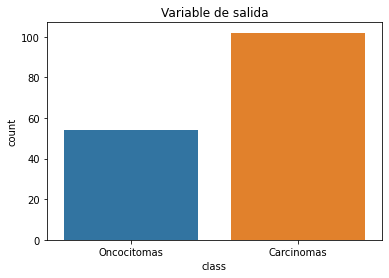

In [9]:
g = sns.countplot(df['class'])
g.set_title('Variable de salida')
g.set_xticklabels(['Oncocitomas','Carcinomas'])

In [10]:
features = df[[c for c in df.columns[6:] if 'diagnostics' not in c and 'class' not in c]]
print(f'{len(features.columns)} features de {len(features)} pacientes')

686 features de 156 pacientes


### Tipos de imagen (image types)

La extracción radiómica se realizó para la volumetría original del tumor, y luego se repitió para versiones procesadas con distintos filtros de imagen. Estos filtros incluyen laplacianos de distintos valores de sigma (cuanto menor el sigma, más fino el análisis de textura); y ocho decomposiciones de una Wavelet Coiflet.

In [11]:
imageTypes = list(np.unique([feature_name.split('_')[0] for feature_name in features.columns]))
imageTypes_features = {}
for imageType in imageTypes:
  imageTypes_features[imageType] = [col for col in features.columns if imageType in col]
print(f"{len(imageTypes_features)} image types\n".upper())
for imageType in imageTypes:
  print(f"{imageType}: {len(imageTypes_features[imageType])} features")

12 IMAGE TYPES

log-sigma-1-0-mm-3D: 56 features
log-sigma-3-0-mm-3D: 56 features
log-sigma-5-0-mm-3D: 56 features
original: 70 features
wavelet-HHH: 56 features
wavelet-HHL: 56 features
wavelet-HLH: 56 features
wavelet-HLL: 56 features
wavelet-LHH: 56 features
wavelet-LHL: 56 features
wavelet-LLH: 56 features
wavelet-LLL: 56 features


Vamos a evaluar si el mismo atributo calculado en distintos image types (filtros) se correlaciona. Tomamos como ejemplo un atributo de textura calculado con la matriz de distancia entre niveles de gris (GLDM: gray-level distance matrix).  

In [12]:
features_with_class = features.copy()
features_with_class['class'] = df['class']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


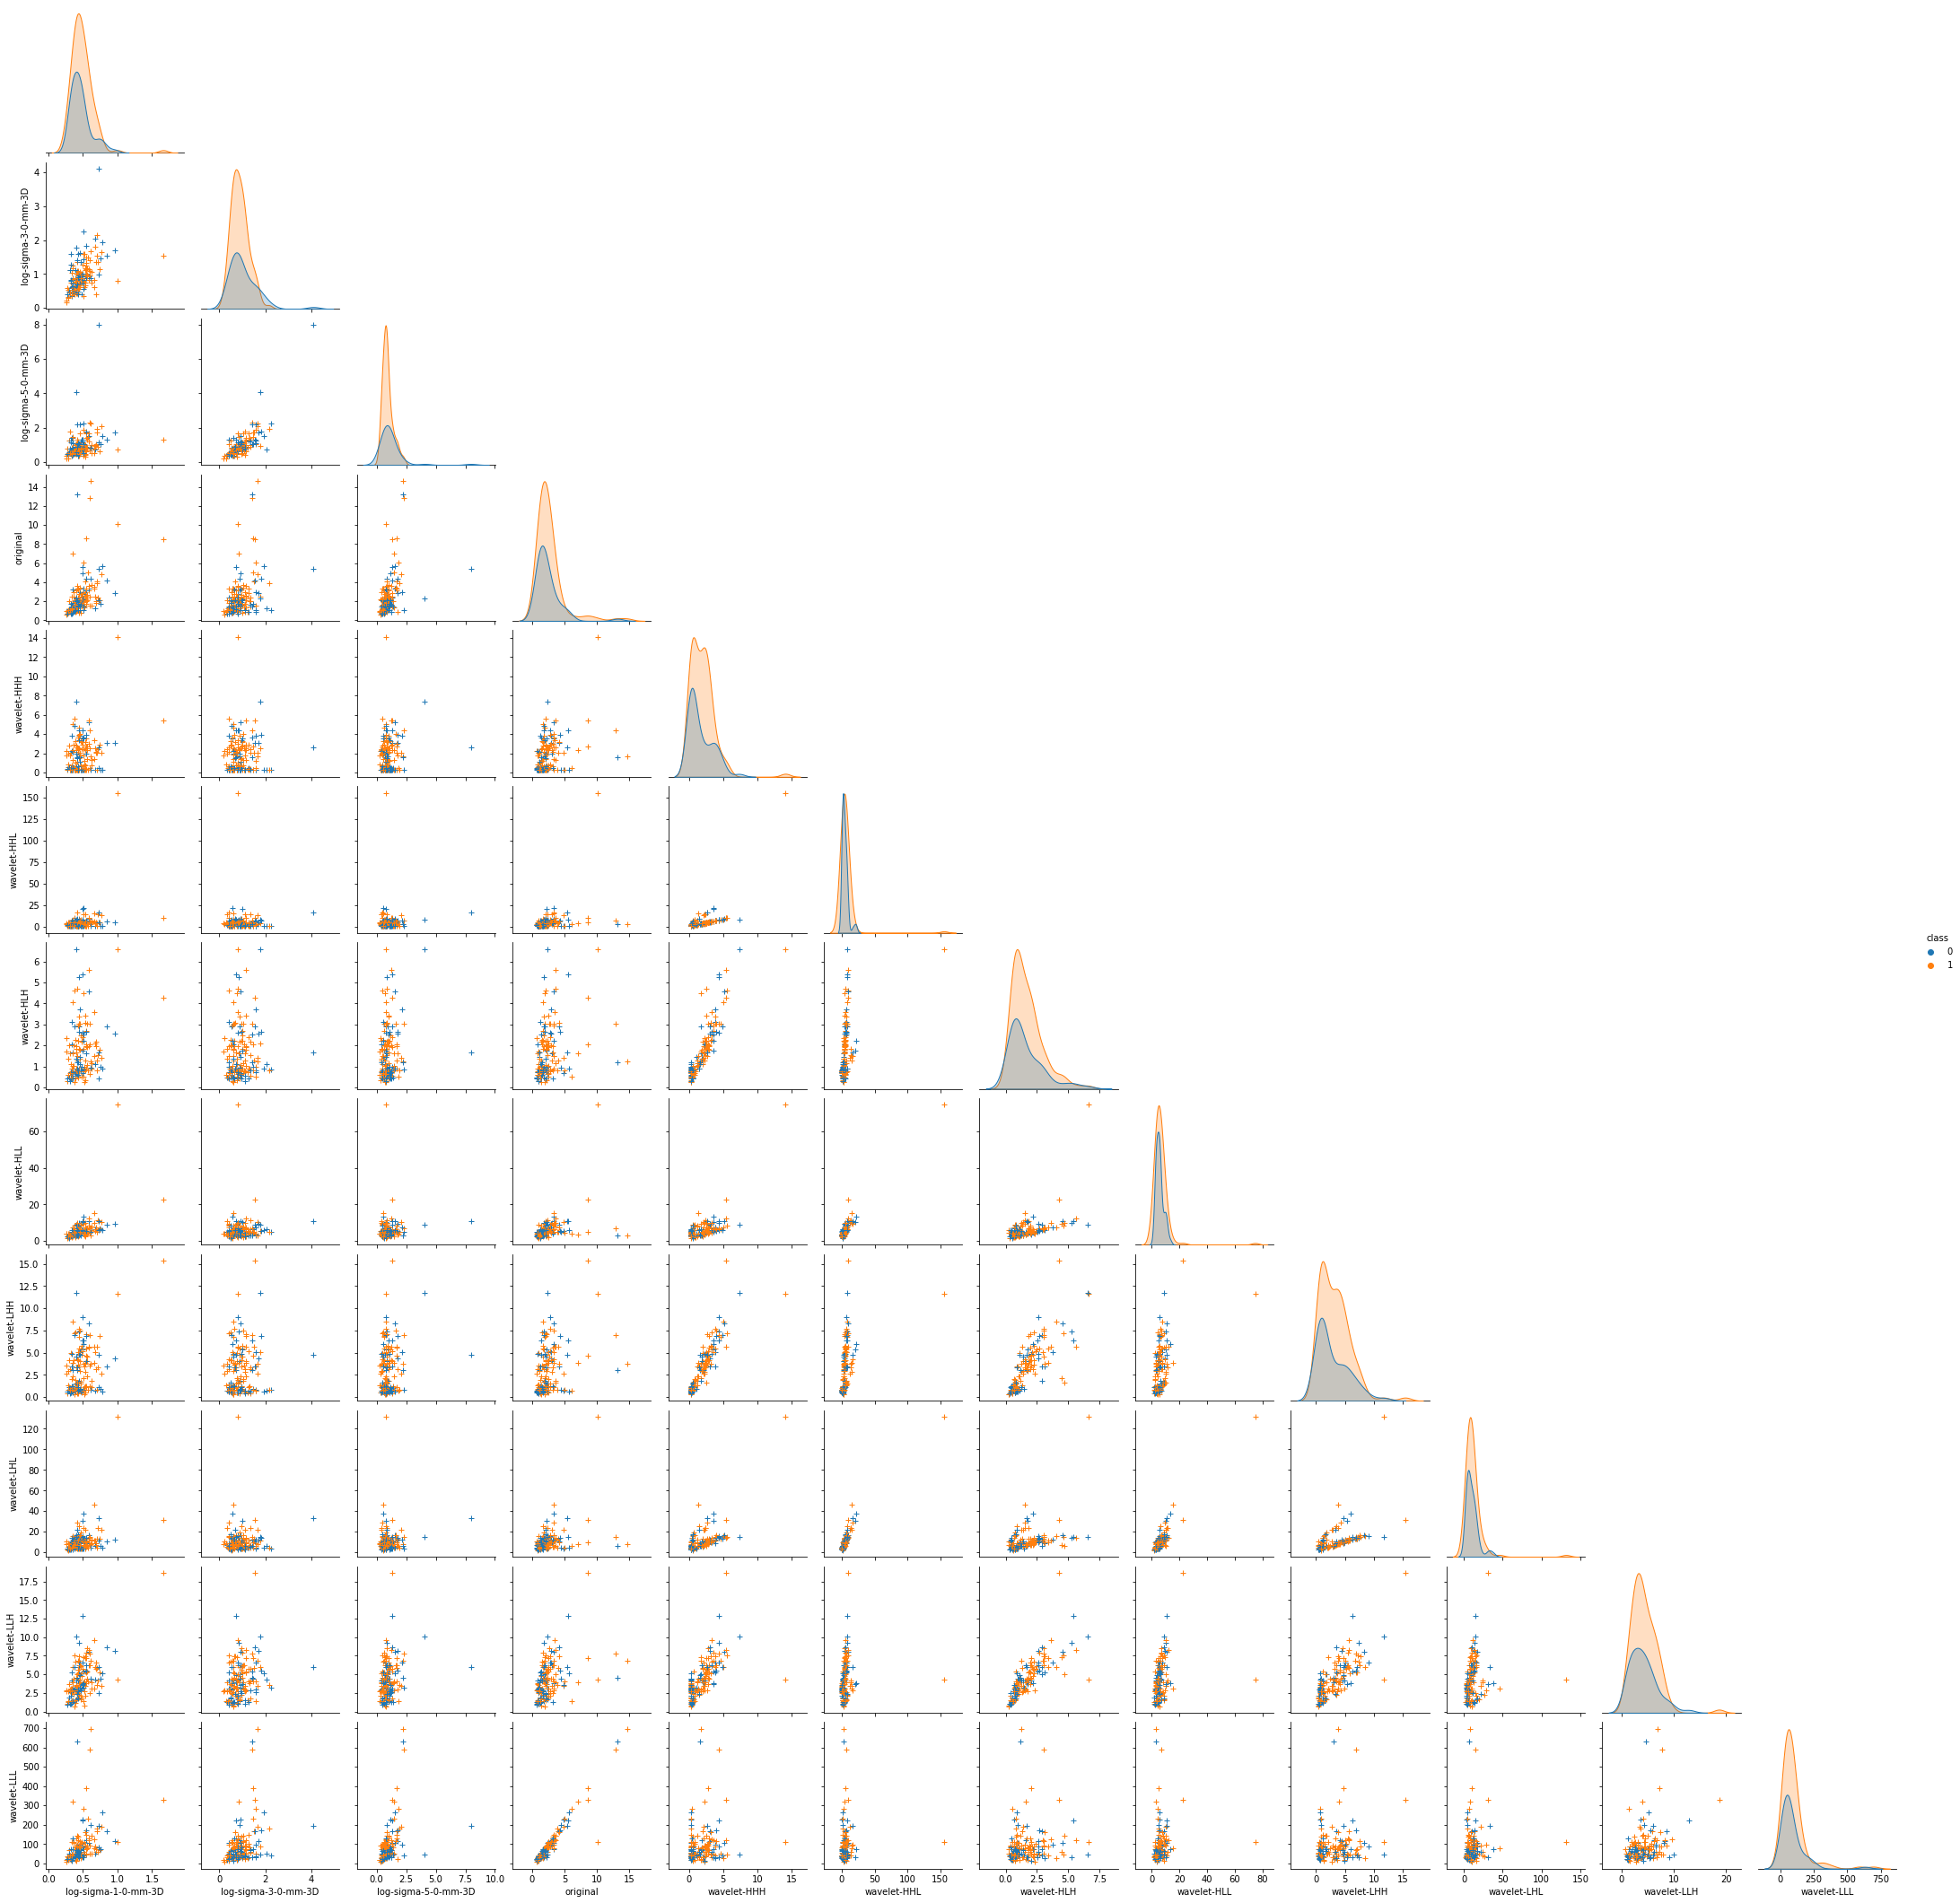

In [16]:

fig,corrMatrix = correlationFeatureByImageTypes(features_with_class,'gldm_GrayLevelVariance',imageTypes)

Hay algunas combinaciones que muestran correlación. Por ejemplo este atributo calculado en la imagen original se correlaciona fuertemente con el calculado en la descomposición wavelet-LLL. Los histogramas de ambas clases parecen pertenecer a dos distribuciones muy similares (misma media, misma forma de la campana), para todos los image types. 

Para eliminar correlación aplicaremos más abajo una selección de atributos de tipo *filter*

### Tipos de atributos

**DESCRIPTORES DE LA FORMA DEL TUMOR** 

Graficamos primero los atributos relacionados a la forma del tumor, buscando visualizar si es diferente entre los carcinomas (malignos, class=1) y oncocitomas(benignos, class=0). Estos atributos se calculan desde la imagen original (imageType=original)

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


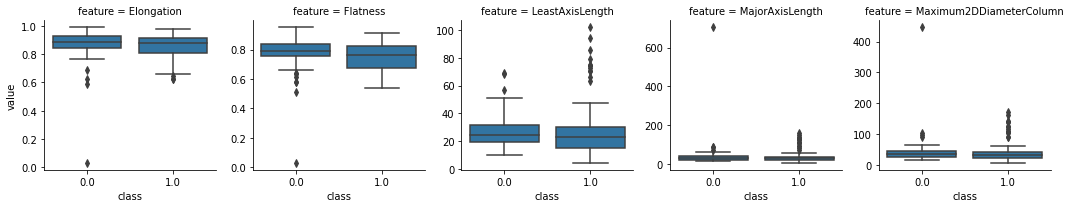

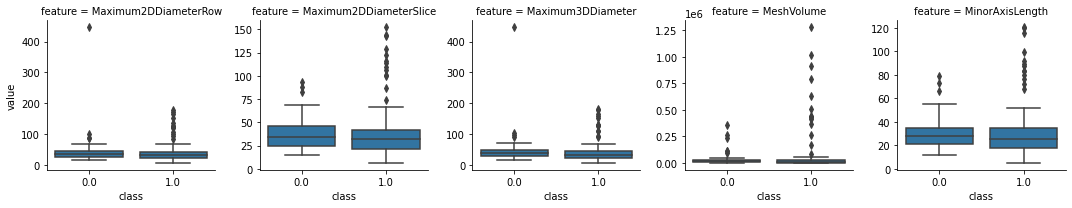

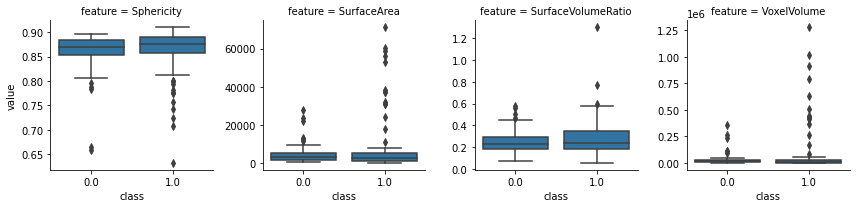

In [14]:

boxPlot(features_with_class,[f for f in features_with_class.columns if 'original_shape' in f][:5])
boxPlot(features_with_class,[f for f in features_with_class.columns if 'original_shape' in f][5:10])
boxPlot(features_with_class,[f for f in features_with_class.columns if 'original_shape' in f][10:])

**DESCRIPTORES DE LA TEXTURA DEL TUMOR** 

Como ejemplo, evaluamos los descriptores obtenidos con la matriz de distancia entre niveles de gris (GLCM), luego de un filtro laplaciano de 3mm

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


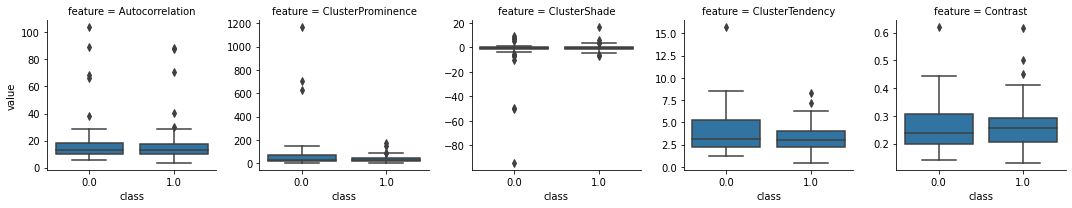

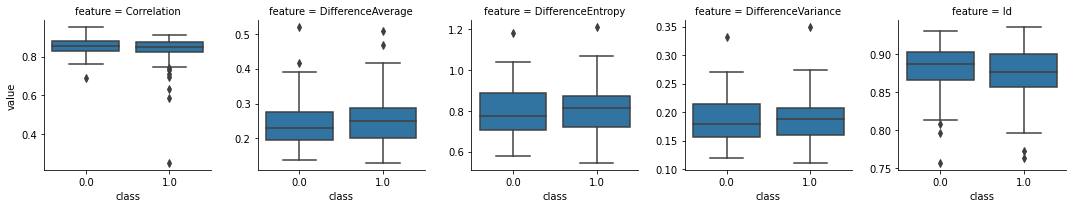

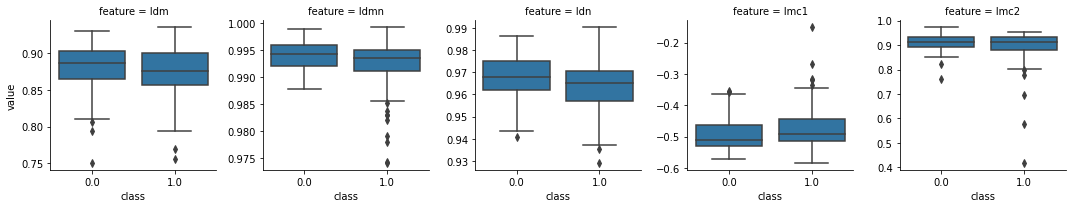

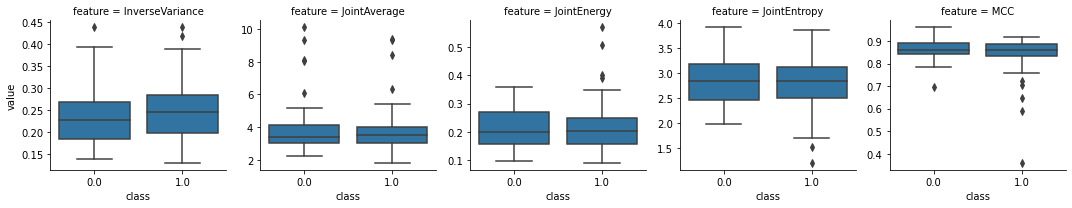

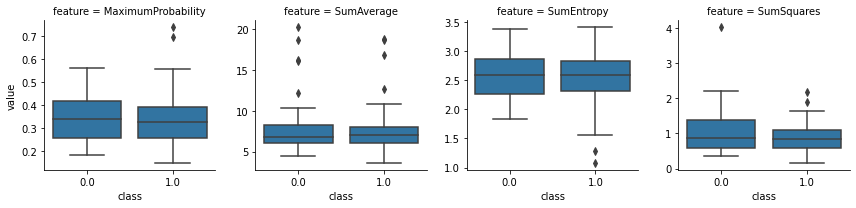

In [15]:
boxPlot(features_with_class,[f for f in features_with_class.columns if 'log-sigma-3-0-mm-3D_glcm' in f][:5])
boxPlot(features_with_class,[f for f in features_with_class.columns if 'log-sigma-3-0-mm-3D_glcm' in f][5:10])
boxPlot(features_with_class,[f for f in features_with_class.columns if 'log-sigma-3-0-mm-3D_glcm' in f][10:15])
boxPlot(features_with_class,[f for f in features_with_class.columns if 'log-sigma-3-0-mm-3D_glcm' in f][15:20])
boxPlot(features_with_class,[f for f in features_with_class.columns if 'log-sigma-3-0-mm-3D_glcm' in f][20:25])


Las distribuciones parecen similares entre tumores. El flatness es levemente inferior para carcionmas. 

### Eliminar features altamente correlacionadas

In [13]:
cor_matrix = features_with_class.drop('class', axis=1).corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.99)]

In [14]:
print('Total a eliminar ', len(to_drop))
print('Cantidad que son shape features ',len([t for t in to_drop if 'shape' in t]))
print('Cantidad que son glcm features ',len([t for t in to_drop if 'glcm' in t]))
print('Cantidad que son first order features ',len([t for t in to_drop if 'firstorder' in t]))

print('\nCantidad que son wavelet features ',len([t for t in to_drop if 'wavelet' in t]))
print('Cantidad que son log sigma features ',len([t for t in to_drop if 'sigma' in t]))
print('Cantidad que son original features ',len([t for t in to_drop if 'original' in t]))

Total a eliminar  231
Cantidad que son shape features  4
Cantidad que son glcm features  120
Cantidad que son first order features  63

Cantidad que son wavelet features  168
Cantidad que son log sigma features  49
Cantidad que son original features  14


In [15]:
features_filtered1 = features.drop(to_drop, axis=1)
print(f'From {features.shape[1]} features to {features_filtered1.shape[1]}')


From 686 features to 455


Examinamos las futures que fueron muy correlacionadas entre sí. Por ejemplo de forma: 


In [16]:
[t for t in to_drop if 'shape' in t]

['original_shape_Maximum2DDiameterRow',
 'original_shape_Maximum3DDiameter',
 'original_shape_MinorAxisLength',
 'original_shape_VoxelVolume']

In [17]:
[t for t in to_drop if 'first' in t]

['original_firstorder_Energy',
 'original_firstorder_RobustMeanAbsoluteDeviation',
 'original_firstorder_RootMeanSquared',
 'original_firstorder_TotalEnergy',
 'log-sigma-1-0-mm-3D_firstorder_Energy',
 'log-sigma-1-0-mm-3D_firstorder_RobustMeanAbsoluteDeviation',
 'log-sigma-1-0-mm-3D_firstorder_RootMeanSquared',
 'log-sigma-1-0-mm-3D_firstorder_TotalEnergy',
 'log-sigma-3-0-mm-3D_firstorder_Energy',
 'log-sigma-3-0-mm-3D_firstorder_RobustMeanAbsoluteDeviation',
 'log-sigma-3-0-mm-3D_firstorder_RootMeanSquared',
 'log-sigma-3-0-mm-3D_firstorder_TotalEnergy',
 'log-sigma-5-0-mm-3D_firstorder_Energy',
 'log-sigma-5-0-mm-3D_firstorder_RobustMeanAbsoluteDeviation',
 'log-sigma-5-0-mm-3D_firstorder_RootMeanSquared',
 'log-sigma-5-0-mm-3D_firstorder_TotalEnergy',
 'wavelet-LLH_firstorder_Energy',
 'wavelet-LLH_firstorder_MeanAbsoluteDeviation',
 'wavelet-LLH_firstorder_RobustMeanAbsoluteDeviation',
 'wavelet-LLH_firstorder_RootMeanSquared',
 'wavelet-LLH_firstorder_TotalEnergy',
 'wavelet-LH

### Eliminar features de baja varianza

Evaluamos qué tanto coinciden con las que se eliminarían por correlación

In [18]:
sel = VarianceThreshold(threshold=(.99 * (1 - .99)))
features_filtered2 = sel.fit_transform(features.copy())

In [19]:
to_drop2 = features.columns[~sel.get_support()]

print(f'From {features.shape[1]} features to {features_filtered2.shape[1]} (dropped {len(to_drop2)} features)')
features_filtered2 = features.drop(to_drop2, axis=1)

From 686 features to 497 (dropped 189 features)


In [20]:
inters = set(to_drop).intersection(set(to_drop2))
print(len(inters))

32


Hay 32 features en comun: altamente correlacionadas y de baja varianza.

Haremos el proceso primero eliminando las de baja varianza y luego las correlacionadas (para evitar que entre dos correlacionadas se elimine la de mayor varianza)

In [21]:
cor_matrix = features_filtered2.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.99)]
features_filtered_final = features_filtered2.drop(to_drop, axis=1)
print(f'From {features.shape[1]} features to {features_filtered_final.shape[1]}')


From 686 features to 299


In [22]:
imageTypes_features_filtered = {}
for imageType in imageTypes:
  imageTypes_features_filtered[imageType] = [col for col in features_filtered_final.columns if imageType in col]
  print(f"{imageType}: {len(imageTypes_features_filtered[imageType])} features")


log-sigma-1-0-mm-3D: 25 features
log-sigma-3-0-mm-3D: 26 features
log-sigma-5-0-mm-3D: 25 features
original: 43 features
wavelet-HHH: 20 features
wavelet-HHL: 19 features
wavelet-HLH: 18 features
wavelet-HLL: 26 features
wavelet-LHH: 21 features
wavelet-LHL: 23 features
wavelet-LLH: 28 features
wavelet-LLL: 25 features


La selección de features fue pareja entre los distintos image types

## Preparar pipeline de algoritmos

Se dividirán los datos en entrenamiento y testeo. Con los datos de entrenamiento se realiza la selección de atributos y el ajuste de clasificadores. Para eso utilizaremos un esquema de validación cruzada de 3 folds y búsqueda por grilla para optimizar la configuración de hiperparámetros

### Preprocesamiento

Se evaluarán dos tipos de escalamiento: estandarización (media cero y desvío unitario), y normalización al rango 0-1.

In [46]:
preProcessedFeatures = {}
preProcessedFeatures['standardScaling'] = StandardScaler().fit_transform(features_filtered_final)
preProcessedFeatures['minMaxScaling'] = MinMaxScaler().fit_transform(features_filtered_final)
pickle.dump(preProcessedFeatures,open(drive_dir+'preProcessedFeatures','wb'))

### Preparar selección de features

Se aplicaron antes métodos de tipo *filter* al eliminar los atributos de baja varianza y alta correlación. Por lo tanto ahora se evaluarán métodos de tipo *wrapper* y *embedding*. 

* Wrapper: SequentialFeatureSelector. Selección secuencial, de tipo greedy, que realiza de forma iterativa la selección de un conjunto de características y el ajuste de un modelo clasificación. La cantidad de features seleccionadas se definió siguiendo una regla general de tener al menos el doble de observaciones que de features. Se prueban dos clasificadores para usar al evaluar el desempeño con las distintas combinaciones de features: regresión logística y vectores de soporte. Lo usaremos tanto forward como backward. Cada posible pipeline se evalúa además en 3 folds, siguiendo un esquema de validación cruzada. 

* Embedding: SelectFromModel. Se seleccionan los atributos más importantes para un clasificador luego de entrenarlo. Por ejemplo, los coeficientes de Lasso o de una regresión logística. En este caso usaremos regresión logística y la importancia de atributos (feature importances) de un vector de soportes de salida lineal.


Además, probaremos una reducción de dimensionalidad por componentes principales

In [47]:

featureSelectors = {}
featureSelectors['embedding-LR'] = SelectFromModel(estimator=LR(random_state=42),threshold='median')
featureSelectors['embedding-SVL'] = SelectFromModel(estimator=LinearSVC(C=0.01, penalty="l1", dual=False,random_state=42),threshold='median')

CV = StratifiedKFold(n_splits=3,shuffle=True,random_state=42)

featureSelectors['wrapper-LR-bw'] = SFS(estimator=LR(random_state=42),direction='backward',cv=CV,n_features_to_select=70)
featureSelectors['wrapper-SVC-bw'] = SFS(estimator=SVC(random_state=42),direction='backward',cv=CV,n_features_to_select=70)
#featureSelectors['wrapper-RF-bw'] = SFS(estimator=RandomForestClassifier(random_state=42),direction='backward',cv=CV,n_features_to_select=70)

featureSelectors['wrapper-LR-fw'] = SFS(estimator=LR(random_state=42),direction='forward',cv=CV,n_features_to_select=70)
featureSelectors['wrapper-SVC-fw'] = SFS(estimator=SVC(random_state=42),direction='forward',cv=CV,n_features_to_select=70)
#featureSelectors['wrapper-RF-fw'] = SFS(estimator=RandomForestClassifier(random_state=42),direction='forward',cv=CV,n_features_to_select=70)

featureSelectors['PCA'] = PCA(random_state=42,n_components=70)



### Preparar clasificadores

Evaluaremos tres algoritmos:

* Regresión logística
* Bosques aleatorios
* Máquina de vectores de soporte

Para cada uno preparamos una grilla de hiperparámetros

In [38]:
models = {}
models['LR'] = LR(random_state=42)
models['RF'] = RandomForestClassifier(random_state=42)
models['SVC'] = SVC(random_state=42)


In [39]:
param_grids = {}


param_grids['LR'] = {'C':np.logspace(-4, 4, 2),
                    'class_weight':['balanced',None],
                    'fit_intercept':[True,False]}

param_grids['RF'] = {'n_estimators':[10,100,200,400],
                    'criterion':['gini','entropy'],
                    'max_depth':[None,4,8,10],
                    'min_samples_split':[2,5],
                    'min_samples_leaf':[1,2,3],
                    'bootstrap':[True,False]}
param_grids['SVC'] = {'C':np.logspace(-4, 4, 4),
                    'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
                    'class_weight':['balanced',None],
                    'shrinking':[True,False]}                     

### División en subsets


Se dividieron las observaciones en un conjunto de entrenamiento y otro de testeo, siguiendo un split estratificado para mantener el balance de clases en ambos conjuntos

In [40]:

idx_train,idx_test = train_test_split(df.index,test_size=.2,random_state=2,shuffle=True,stratify=df['class'])


In [41]:
print(f'TRAIN (n={len(idx_train)})\n',df.loc[idx_train,'class'].value_counts())
print(f'\nTEST (n={len(idx_test)})\n',df.loc[idx_test,'class'].value_counts())


TRAIN (n=124)
 1    81
0    43
Name: class, dtype: int64

TEST (n=32)
 1    21
0    11
Name: class, dtype: int64


## Entrenamiento 

A continuación ajustamos modelos para las distintas combinaciones de método de normalización (estándar o min-max), selector de atributos, y algoritmo de clasificación. Para cada algoritmo se realiza la búsqueda por grilla de hiperparámetros, repitiendo el proceso para tres folds en esquema de validación cruzada. Se selecciona como mejor estimador aquel con máxima valor de F1 score promedio entre los 3 folds. 

Cabe aclarar que inicialmente intentamos ejecutar todos los entrenamientos como un Pipeline de Sklearn. Sin embargo, comprobamos que la seleccion de atributos con métodos wrapper consume significativamente más tiempo que los métodos embedding (debido a la alta cantidad de repeticiones necesaria). En estos últimos, el ajuste como pipeline completo resultaba imposible de entrenar en una sesión de Colab. Por eso, para los métodos no embeddings hacemos primero el ajuste del selector y luego el ajuste de la búsqueda por grilla. 

Se implementó en varias corridas distintas ya que se terminaba el tiempo de Colab, por eso se guardaban los resultados como archivos binarios con pickle para luego evaluarlos en conjunto.

In [42]:
os.makedirs(drive_dir+'gridSearchs',exist_ok=True)
for preprocessName, preprocess in preProcessedFeatures.items():
  x_ = preprocess[idx_train,:]  #Normalizacion
  y = df.loc[idx_train,'class'].values
  for featureSelectorName, featureSelector in featureSelectors.items():
    if 'embedded' not in featureSelectorName:
      x = featureSelector.fit_transform(x_,y)   #Ajustar selector 
    for algorithmName,model in models.items(): 
      savingPath = drive_dir+'gridSearchs/{}_{}_{}'.format(preprocessName,featureSelectorName,algorithmName)
      ## Como esto requirió varias corridas porque se cortaba la sesión de Colab, guardamos y retomamos desde el último realizado
      if not os.path.exists(savingPath):
        print('\n\n\n---------------Starting search with {} preprocess, {} feature selection and {} model---------------\n\n\n'.format(preprocessName,
                                                                                                                                       featureSelectorName,
                                                                                                                                       algorithmName))
        if 'embedded' in featureSelectorName:
          grid_dict = dict(zip([f"{algorithmName}__{k}" for k in param_grids[algorithmName].keys()],
                              param_grids[algorithmName].values()))
          steps = [(algorithmName,grid_dict)]         
          pipe = Pipeline(steps=[('selector', featureSelector), 
                                (algorithmName, model)])
          search = GridSearchCV(pipe, grid_dict,cv=CV,scoring='f1')
          search.fit(x_, y)  #Fitear con el vector x original
        else:

          grid_dict = param_grids[algorithmName]
          search = GridSearchCV(model, grid_dict,cv=CV,scoring='f1')

        search.fit(x, y)
      
      
        print("\n\n\n---------------Best parameter (CV score=%0.3f):---------------\n\n\n" % search.best_score_)
        print(search.best_params_)
        print("\n\n\n---------------------------------------------\n\n\n")
        pickle.dump([featureSelector,search],open(savingPath,'wb'))






---------------Starting search with standardScaling preprocess, PCA feature selection and LR model---------------





/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression





---------------Best parameter (CV score=0.790):---------------



{'C': 0.0001, 'class_weight': None, 'fit_intercept': True}



---------------------------------------------






---------------Starting search with standardScaling preprocess, PCA feature selection and RF model---------------






---------------Best parameter (CV score=0.798):---------------



{'bootstrap': False, 'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}



---------------------------------------------






---------------Starting search with standardScaling preprocess, PCA feature selection and SVC model---------------






---------------Best parameter (CV score=0.790):---------------



{'C': 0.0001, 'class_weight': None, 'kernel': 'linear', 'shrinking': True}



---------------------------------------------





## Comparar pipelines

Vamos a evaluar el desempeño de los distintos pipelines en el conjunto de test. Además, vamos a comparar que features fueron seleccionadas por los distintos métodos, y el promedio de F1 score obtenido en testeo. 

En testeo vamos a calcular una serie completa de métricas, que cuantifiquen tanto la discriminación como la calibración del modelo:

* AUCROC: Área bajo la curva ROC. Expresa el compromiso entre sensibilidad y especificidad a lo largo de todos los puntos de operación del modelo.
* AUCPR: Área bajo la curva de precision-recall. Expresa el compromiso entre precisión y sensibilidad. Es importante evaluarla porque el dataset no está completamente balanceado, y el valor AUCROC podría estar siendo dominado por la clase mayoritaria. 
* Matriz de confusión: para el punto de operación por defecto de Sklearn, calculamos la cantidad de verdaderos positivos (carcinomas clasificados bien), verdaderos negativos (oncocitomas clasificados bien), falsos positivos (oncocitomas clasificados mal), y falsos negativos (carcinomas clasificados mal)
* Métricas tradicionales de Machine Learning: para ese punto de operación, calculamos recall, precision, F1 score, specificity y negative predictive value
* Brier scores: esta métrica es una medida completa de desempeño (afectada tanto por la discriminación como por la calibración del modelo). Es una "proper scoring rule", ya que alcanza su valor ideal (=0), cuando los outputs del modelo representan la distribución de probabilidades a posteriori de las clases. Además, lo evaluamos por separado para la clase minoritaria y la mayoritaria (Brier+ y Brier-), para verificar si el desempeño es parejo en ambas clases.

In [51]:
def getTestResults(search,selector_,x_test,y_test): 
  selected_features = []
  if hasattr(selector_,"get_support"):
    selected_features = features_filtered_final.columns[selector_.get_support()]
    print(f'{len(selected_features)} features selected'.upper())
  print('\n')
  print('Best F1 score in training: ', search.best_score_)
  print('\n')

  test_preds = search.best_estimator_.predict(x_test)
  try:
    test_preds_proba = search.best_estimator_.predict_proba(x_test)[:,1]
  except:
    test_preds_proba = test_preds.copy()
  (tn, fp, fn, 
   tp), (sens, spec, ppv, 
         npv), (acc, f1score, aucroc,
                aucpr), (brier,brierPos,
                         brierNeg) = getClassificationMetrics(test_preds,y_test,cont_preds=test_preds_proba)
  dfRow = {
           'TotalFeatures':len(selected_features), 'F1-TRAIN':search.best_score_,
           'Sensitivity':sens,'Specificity':spec,'F1':f1score,'Accuracy':acc,'Precision':ppv,'NPV':npv,
           'TP':tp,'TN':tn,'FP':fp,'FN':fn,
           'AUCROC':aucroc,'AUCPR':aucpr,'Brier':brier,'Brier+':brierPos,'Brier-':brierNeg}
  results = {'selectedFeatures':selected_features,
             'testPreds':test_preds,
             'testProbas':test_preds_proba}  
  return dfRow,results

Evaluamos cada pipeline en el set de testeo, y almacenamos las métricas en un dataframe. Además, se guardan las predicciones obtenidas como archivo binario para procesarlas luego

In [73]:
dfResults = pd.DataFrame()
trained_pipelines = os.listdir(drive_dir+'gridSearchs')
os.makedirs(drive_dir+'testResults',exist_ok=True)
for pipeline in trained_pipelines:
  preprocess = pipeline.split('_')[0]
  selector = pipeline.split('_')[1]
  model = pipeline.split('_')[2]
  x_test = preProcessedFeatures[preprocess][idx_test,:]
  y_test = df.loc[idx_test,'class'].values

  print('\n--------------------------------------\n')
  print(pipeline)
  print('\n--------------------------------------\n')
  
  trainedPipeline = pickle.load(open(drive_dir+'gridSearchs/'+pipeline,'rb'))
  print(trainedPipeline)
  if isinstance(trainedPipeline,list):
    selector_ = trainedPipeline[0]
    search = trainedPipeline[1]
    x_test = selector_.transform(x_test)
  else:
    selector_ = trainedPipeline.best_estimator_[0]
    search = trainedPipeline
  if not isinstance(search,list):
    dfRow,results = getTestResults(search,selector_,x_test,y_test)  
    dfRow['ImageType']='All' 
  dfRow['Preprocess']=preprocess
  dfRow['Selector']=selector
  dfRow['Model']=model   
  dfResults = dfResults.append(dfRow,ignore_index=True)                  

  print('\n--------------------------------------\n')
  pickle.dump(results,open(drive_dir+'testResults/'+pipeline,'wb'))
dfResults = dfResults[['Preprocess','ImageType', 'Selector','TotalFeatures','Model','F1-TRAIN', 
                       'AUCPR', 'AUCROC','Brier', 'Brier+', 'Brier-',
                       'Accuracy', 'F1', 'Sensitivity', 'Specificity', 'NPV', 'Precision', 'TP','TN','FP','FN'
                       ]]
dfResults.to_csv(drive_dir+'dfResults.csv',index=False)


--------------------------------------

minMaxScaling_embedding-LR_LR

--------------------------------------

[SelectFromModel(estimator=LogisticRegression(random_state=42),
                threshold='median'), GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=LogisticRegression(random_state=42),
             param_grid={'C': array([1.e-04, 1.e+04]),
                         'class_weight': ['balanced', None],
                         'fit_intercept': [True, False]},
             scoring='f1')]
150 FEATURES SELECTED


Best F1 score in training:  0.8040183537263627


AUCROC: 0.788
AUCPR: 0.874
Confusion matrix:  [ 4  7  0 21]
True negatives:4
True positives:21
False negatives:0
False positives:7

Sensitivity(recall):1.00
Specificity:0.36
PPV(precision):0.75
NPV:1.00

f1-score:0.857
accuracy:0.781
brier 0.219. brier+ 0.250. brier- 0.250

--------------------------------------


--------------------------------------

minMaxScaling_wrappe

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars


AUCROC: 0.879
AUCPR: 0.932
Confusion matrix:  [ 4  7  1 20]
True negatives:4
True positives:20
False negatives:1
False positives:7

Sensitivity(recall):0.95
Specificity:0.36
PPV(precision):0.74
NPV:0.80

f1-score:0.833
accuracy:0.750
brier 0.250. brier+ 0.103. brier- 0.293

--------------------------------------


--------------------------------------

minMaxScaling_wrapper-SVC-bw_SVC

--------------------------------------

[SequentialFeatureSelector(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                          direction='backward', estimator=SVC(random_state=42),
                          n_features_to_select=70), GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=SVC(random_state=42),
             param_grid={'C': array([1.00000000e-04, 4.64158883e-02, 2.15443469e+01, 1.00000000e+04]),
                         'class_weight': ['balanced', None],
                         'kernel': ['linear', 'poly', 'rbf', 's

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars


[SequentialFeatureSelector(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                          direction='backward', estimator=SVC(random_state=42),
                          n_features_to_select=70), GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 4, 8, 10],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 100, 200, 400]},
             scoring='f1')]
70 FEATURES SELECTED


Best F1 score in training:  0.7665963540326867


AUCROC: 0.814
AUCPR: 0.877
Confusion matrix:  [ 6  5  2 19]
True negatives:6
True positives:19
False negatives:2
False positives:5

Sensitivity(recall):0.90
Specificity:0.55
PPV(precision):0.79
NPV

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars



--------------------------------------

standardScaling_wrapper-SVC-fw_SVC

--------------------------------------

[SequentialFeatureSelector(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                          estimator=SVC(random_state=42),
                          n_features_to_select=70), GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=SVC(random_state=42),
             param_grid={'C': array([1.00000000e-04, 4.64158883e-02, 2.15443469e+01, 1.00000000e+04]),
                         'class_weight': ['balanced', None],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'shrinking': [True, False]},
             scoring='f1')]
70 FEATURES SELECTED


Best F1 score in training:  0.7941176470588235


AUCROC: 0.545
AUCPR: 0.839
Confusion matrix:  [ 1 10  0 21]
True negatives:1
True positives:21
False negatives:0
False positives:10

Sensitivity(recall):1.00
Specificity:0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars


 [ 0 11  0 21]
True negatives:0
True positives:21
False negatives:0
False positives:11

Sensitivity(recall):1.00
Specificity:0.00
PPV(precision):0.66
NPV:nan

f1-score:0.792
accuracy:0.656
brier 0.344. brier+ 0.121. brier- 0.414

--------------------------------------


--------------------------------------

standardScaling_embedding-SVL_LR

--------------------------------------

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('selector',
                                        SelectFromModel(estimator=LinearSVC(C=0.01,
                                                                            dual=False,
                                                                            penalty='l1',
                                                                            random_state=42),
                                                        threshold='median')),
                                       ('LR',
       

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars



--------------------------------------


--------------------------------------

standardScaling_embedding-LR_RF

--------------------------------------

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('selector',
                                        SelectFromModel(estimator=LogisticRegression(random_state=42),
                                                        threshold='median')),
                                       ('RF',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'RF__bootstrap': [True, False],
                         'RF__criterion': ['gini', 'entropy'],
                         'RF__max_depth': [None, 4, 8, 10],
                         'RF__min_samples_leaf': [1, 2, 3],
                         'RF__min_samples_split': [2, 5],
                         'RF__n_estimators': [10, 100, 200, 400]},
             scoring='f1')
150 FEATURES S

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars


AUCROC: 0.545
AUCPR: 0.839
Confusion matrix:  [ 1 10  0 21]
True negatives:1
True positives:21
False negatives:0
False positives:10

Sensitivity(recall):1.00
Specificity:0.09
PPV(precision):0.68
NPV:1.00

f1-score:0.808
accuracy:0.688
brier 0.312. brier+ 0.000. brier- 0.909

--------------------------------------


--------------------------------------

minMaxScaling_embedding-SVL_RF

--------------------------------------

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('selector',
                                        SelectFromModel(estimator=LinearSVC(C=0.01,
                                                                            dual=False,
                                                                            penalty='l1',
                                                                            random_state=42),
                                                        threshold='median')),
         

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars



--------------------------------------


--------------------------------------

minMaxScaling_PCA_SVC

--------------------------------------

[PCA(n_components=70, random_state=42), GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=SVC(random_state=42),
             param_grid={'C': array([1.00000000e-04, 4.64158883e-02, 2.15443469e+01, 1.00000000e+04]),
                         'class_weight': ['balanced', None],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'shrinking': [True, False]},
             scoring='f1')]


Best F1 score in training:  0.7902813299232737


AUCROC: 0.500
AUCPR: 0.828
Confusion matrix:  [ 0 11  0 21]
True negatives:0
True positives:21
False negatives:0
False positives:11

Sensitivity(recall):1.00
Specificity:0.00
PPV(precision):0.66
NPV:nan

f1-score:0.792
accuracy:0.656
brier 0.344. brier+ 0.000. brier- 1.000

--------------------------------------


--------

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars


Estudiamos que tipo de atributos se seleccionaron (de qué image types)

In [75]:
print(len(trained_pipelines))
trained_pipelines

44


['minMaxScaling_embedding-LR_LR',
 'minMaxScaling_wrapper-LR-fw_LR',
 'minMaxScaling_wrapper-LR-bw_LR',
 'minMaxScaling_wrapper-LR-bw_RF',
 'minMaxScaling_wrapper-LR-bw_SVC',
 'minMaxScaling_wrapper-SVC-bw_LR',
 'minMaxScaling_wrapper-SVC-bw_RF',
 'minMaxScaling_wrapper-SVC-bw_SVC',
 'standardScaling_wrapper-LR-bw_LR',
 'standardScaling_wrapper-LR-bw_RF',
 'standardScaling_wrapper-LR-bw_SVC',
 'standardScaling_wrapper-SVC-bw_LR',
 'standardScaling_wrapper-SVC-bw_RF',
 'standardScaling_wrapper-SVC-bw_SVC',
 'standardScaling_wrapper-LR-fw_LR',
 'standardScaling_wrapper-LR-fw_RF',
 'standardScaling_wrapper-LR-fw_SVC',
 'minMaxScaling_wrapper-LR-fw_SVC',
 'minMaxScaling_wrapper-LR-fw_RF',
 'standardScaling_wrapper-SVC-fw_LR',
 'minMaxScaling_wrapper-SVC-fw_LR',
 'standardScaling_wrapper-SVC-fw_RF',
 'standardScaling_wrapper-SVC-fw_SVC',
 'minMaxScaling_wrapper-SVC-fw_RF',
 'minMaxScaling_wrapper-SVC-fw_SVC',
 'minMaxScaling_PCA_LR',
 'minMaxScaling_PCA_LR (1)',
 'standardScaling_PCA_LR',
 

In [76]:
count_selected_features = pd.DataFrame()
for pipeline in trained_pipelines:
  if 'PCA' not in pipeline:
    print('\n\n\n',pipeline)
    preprocess = pipeline.split('_')[0]
    selector = pipeline.split('_')[1]
    model = pipeline.split('_')[2]

    results = pickle.load(open(drive_dir+'testResults/'+pipeline,'rb'))
    best_features_selected = results['selectedFeatures']
    selected_features_types = {}
    counts = {}
    for imageType in imageTypes:
      selected_features_types[imageType] = [col for col in best_features_selected if imageType in col]
      counts[imageType] = len(selected_features_types[imageType]) 
      print(f"{imageType}: {counts[imageType]} features")    
      count_selected_features = count_selected_features.append({'pipeline':pipeline,'selector':selector,'model':model,'preprocess':preprocess,
                                                                'imageType':imageType,'count':counts[imageType]},ignore_index=True)




 minMaxScaling_embedding-LR_LR
log-sigma-1-0-mm-3D: 20 features
log-sigma-3-0-mm-3D: 17 features
log-sigma-5-0-mm-3D: 14 features
original: 27 features
wavelet-HHH: 3 features
wavelet-HHL: 8 features
wavelet-HLH: 8 features
wavelet-HLL: 12 features
wavelet-LHH: 7 features
wavelet-LHL: 5 features
wavelet-LLH: 11 features
wavelet-LLL: 18 features



 minMaxScaling_wrapper-LR-fw_LR
log-sigma-1-0-mm-3D: 6 features
log-sigma-3-0-mm-3D: 6 features
log-sigma-5-0-mm-3D: 4 features
original: 18 features
wavelet-HHH: 3 features
wavelet-HHL: 3 features
wavelet-HLH: 1 features
wavelet-HLL: 8 features
wavelet-LHH: 4 features
wavelet-LHL: 6 features
wavelet-LLH: 10 features
wavelet-LLL: 1 features



 minMaxScaling_wrapper-LR-bw_LR
log-sigma-1-0-mm-3D: 2 features
log-sigma-3-0-mm-3D: 1 features
log-sigma-5-0-mm-3D: 1 features
original: 1 features
wavelet-HHH: 17 features
wavelet-HHL: 6 features
wavelet-HLH: 7 features
wavelet-HLL: 5 features
wavelet-LHH: 3 features
wavelet-LHL: 2 features
wavelet

In [77]:
count_selected_features.shape

(444, 6)

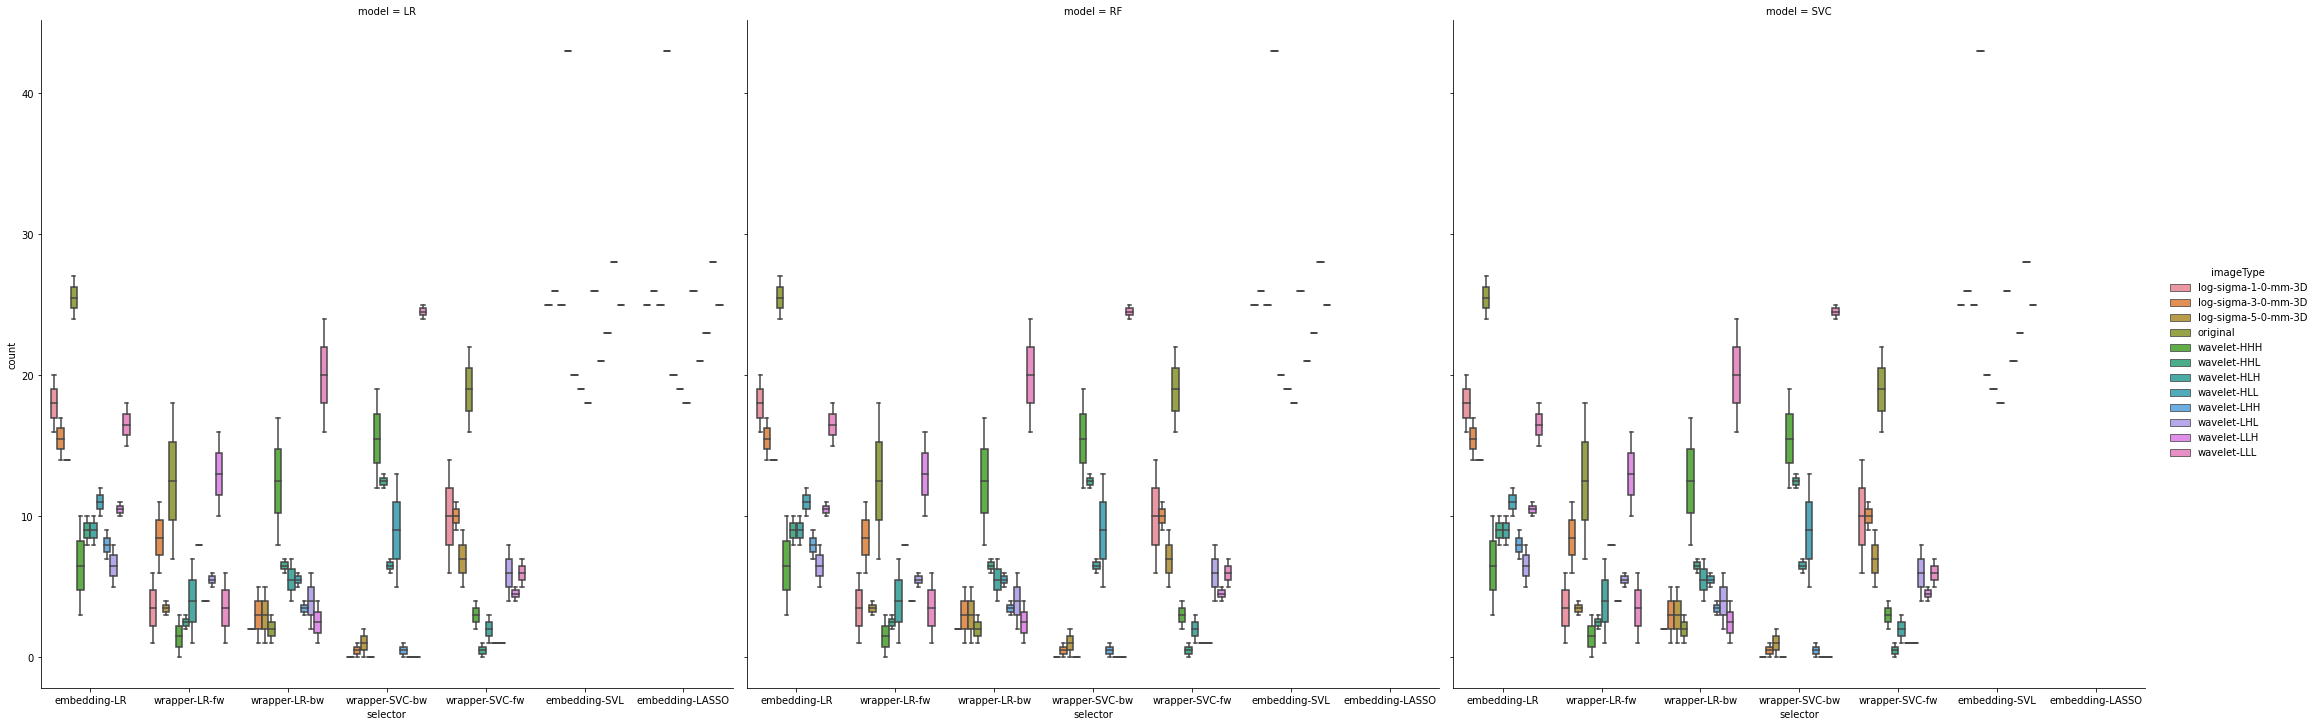

In [88]:
g = sns.catplot(x="selector", y="count",
                hue="imageType", col="model",
                data=count_selected_features, kind="box",
                height=10, aspect=1
                )

Ahora evaluamos graficamente la comparación de las métricas de performance independientes del umbral de binarización: áreas bajo la curva y brier

In [84]:
dfExtended = pd.DataFrame()
for i,row in dfResults.iterrows():
  for metric in ['AUCPR', 'AUCROC','Brier']:
    newrow={}
    newrow['Preprocess'] = row['Preprocess'] 
    newrow['Selector'] = row['Selector'] 
    newrow['Model'] = row['Model'] 
    newrow['TotalFeatures'] = row['TotalFeatures'] 
    newrow['Metric'] = metric
    newrow['Value'] = row[metric] 
    dfExtended=dfExtended.append(newrow,ignore_index=True)

Text(0.5, 0.98, 'REGRESION LOGISTICA')

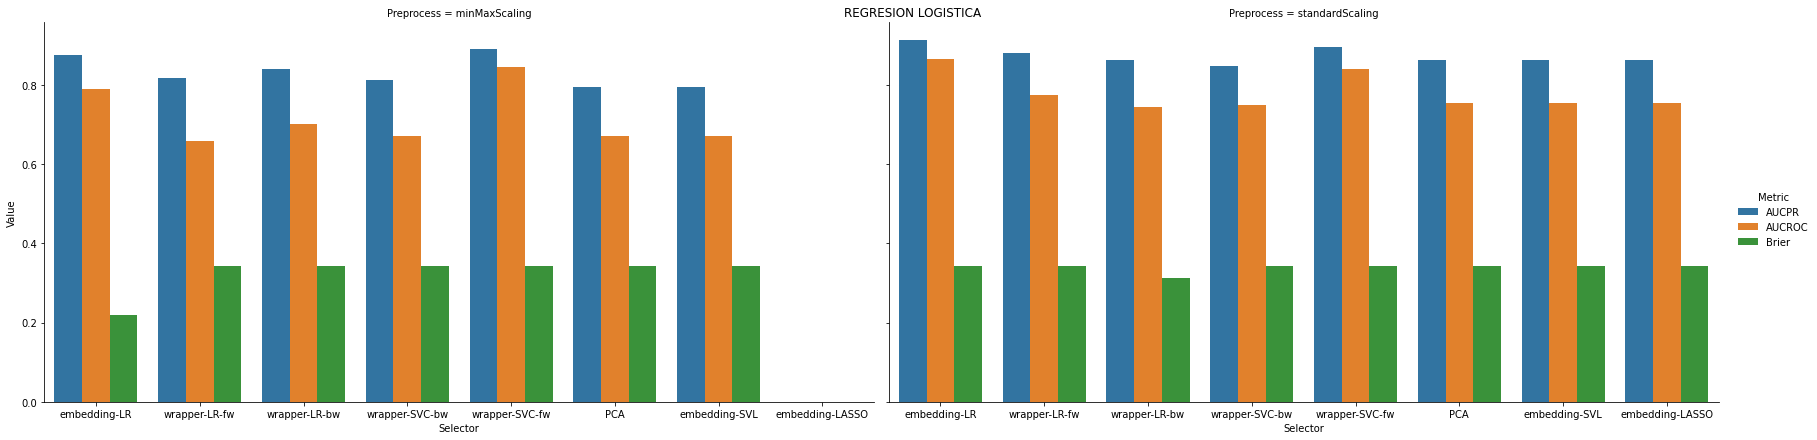

In [99]:

g = sns.catplot(x="Selector", y="Value",
                hue="Metric", col="Preprocess",
                data=dfExtended[dfExtended.Model=='LR'], kind="bar",
                height=6, aspect=2
                )
g.fig.suptitle('REGRESION LOGISTICA')


Los mejores pipelines para regresión logística fueron el embedding con regresión logística (embedding-LR) con estandarización previa (standardScaling) y el wrapper forward con vector de soporte con minMaxScaling previo. Por otro lado, el embedding con regresion logistica con minMaxScaling muestra un poder discriminativo similar (AUCs similares) pero una mejor calibración (menor Brier). Esto es esperable ya que la regresión logística es un modelo naturalmente calibrado

Text(0.5, 0.98, 'RANDOM FOREST')

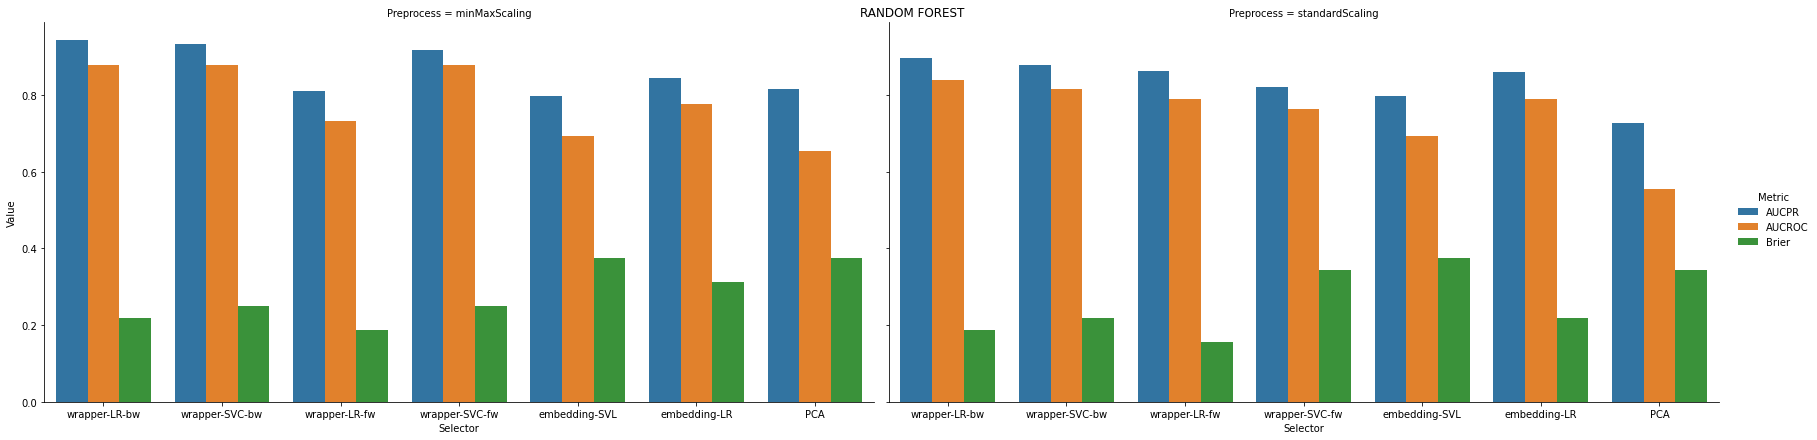

In [100]:
g = sns.catplot(x="Selector", y="Value",
                hue="Metric", col="Preprocess",
                data=dfExtended[dfExtended.Model=='RF'], kind="bar",
                height=6, aspect=2
                )
g.fig.suptitle('RANDOM FOREST')

Los mejores pipelines para random forest son el wrapper regresión logística backwards (wrapper-LR-bw) para el standardScaling, ya que tiene AUCs similares a las demás pero menor brier. Compite con el mismo pipeline pero usando minMaxScaling

Text(0.5, 0.98, 'SUPPORT VECTORS')

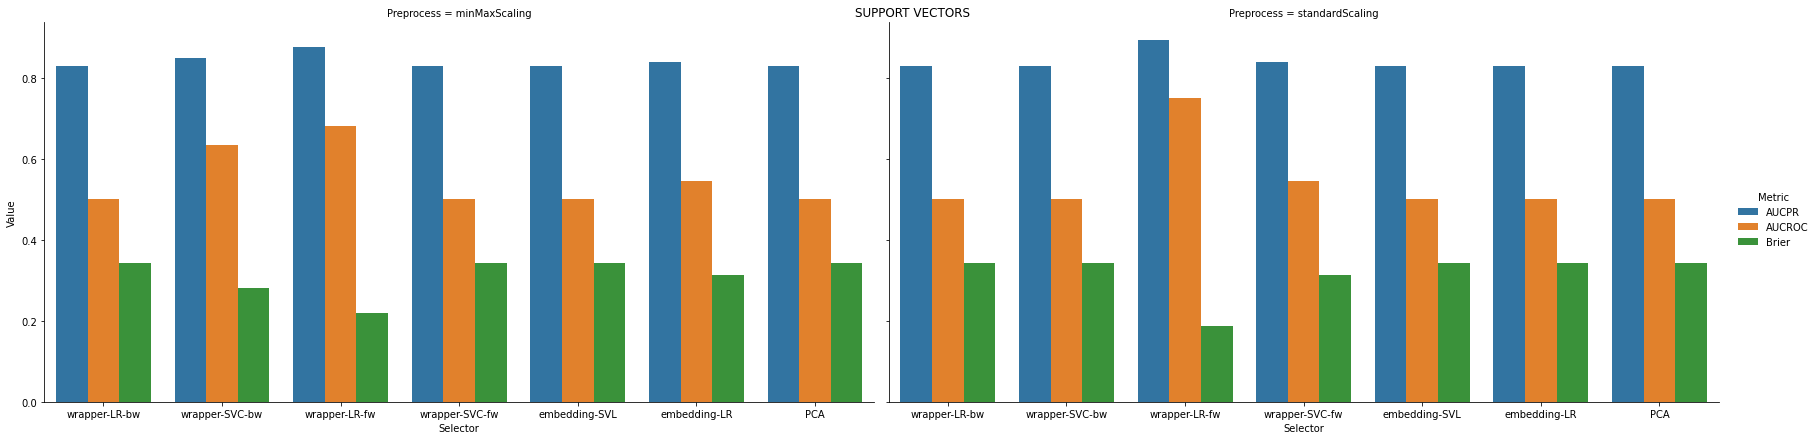

In [98]:
g = sns.catplot(x="Selector", y="Value",
                hue="Metric", col="Preprocess",
                data=dfExtended[dfExtended.Model=='SVC'], kind="bar",
                height=6, aspect=2
                )
g.fig.suptitle('SUPPORT VECTORS')

En el caso de support vector classifier, los mejores pipelines no alcanzan tan buenas métricas como los dos algoritmos anteriores. Lo más alto es un AUCPR cercano a 0.9 pero con un AUCROC menor que 0.8

In [102]:
dfResults.sort_values(['AUCROC','AUCPR'],ascending=False)

,Preprocess,ImageType,Selector,TotalFeatures,Model,F1-TRAIN,AUCPR,AUCROC,Brier,Brier+,Brier-,Accuracy,F1,Sensitivity,Specificity,NPV,Precision,TP,TN,FP,FN
3,minMaxScaling,All,wrapper-LR-bw,70.0,RF,0.806252,0.941582,0.878788,0.21875,0.127321,0.202561,0.78125,0.829268,0.809524,0.727273,0.666667,0.850000,17.0,8.0,3.0,4.0
6,minMaxScaling,All,wrapper-SVC-bw,70.0,RF,0.760365,0.932264,0.878788,0.25000,0.103178,0.293232,0.75000,0.833333,0.952381,0.363636,0.800000,0.740741,20.0,4.0,7.0,1.0
23,minMaxScaling,All,wrapper-SVC-fw,70.0,RF,0.801577,0.916308,0.878788,0.25000,0.112725,0.270792,0.75000,0.833333,0.952381,0.363636,0.800000,0.740741,20.0,4.0,7.0,1.0
34,standardScaling,All,embedding-LR,150.0,LR,0.790281,0.911392,0.865801,0.34375,0.120272,0.418812,0.65625,0.792453,1.000000,0.000000,NaN,0.656250,21.0,0.0,11.0,0.0
20,minMaxScaling,All,wrapper-SVC-fw,70.0,LR,0.800059,0.890890,0.844156,0.34375,0.249759,0.250145,0.65625,0.792453,1.000000,0.000000,NaN,0.656250,21.0,0.0,11.0,0.0
19,standardScaling,All,wrapper-SVC-fw,70.0,LR,0.790281,0.895778,0.839827,0.34375,0.119939,0.422602,0.65625,0.792453,1.000000,0.000000,NaN,0.656250,21.0,0.0,11.0,0.0
9,standardScaling,All,wrapper-LR-bw,70.0,RF,0.788233,0.895029,0.839827,0.18750,0.127249,0.248226,0.81250,0.863636,0.904762,0.636364,0.777778,0.826087,19.0,7.0,4.0,2.0
12,standardScaling,All,wrapper-SVC-bw,70.0,RF,0.766596,0.876562,0.813853,0.21875,0.101939,0.303782,0.78125,0.844444,0.904762,0.545455,0.750000,0.791667,19.0,6.0,5.0,2.0
0,minMaxScaling,All,embedding-LR,150.0,LR,0.804018,0.873684,0.787879,0.21875,0.249647,0.250132,0.78125,0.857143,1.000000,0.363636,1.000000,0.750000,21.0,4.0,7.0,0.0
15,standardScaling,All,wrapper-LR-fw,70.0,RF,0.775915,0.862795,0.787879,0.15625,0.119443,0.279062,0.84375,0.893617,1.000000,0.545455,1.000000,0.807692,21.0,6.0,5.0,0.0


Elegimos como mejor pipeline el algoritmo de Random Forest usando un selector de features wrapper backwards optimizado para un regresor logístico y con normalización min-max, que tiene el AUCROC más alto, un muy buen AUCPR y un Brier bajo.

## Evaluación del mejor pipeline


In [ ]:
from sklearn.manifold import TSNE
pipeline = "minMaxScaling_wrapper-LR-bw_RF"
results = pickle.load(open(drive_dir+'testResults/'+pipeline,'rb'))


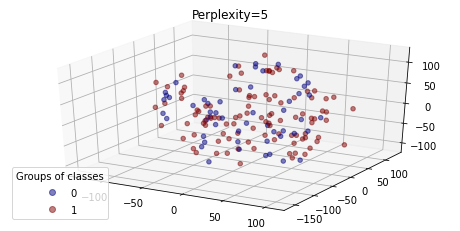

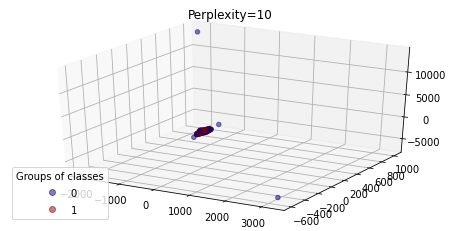

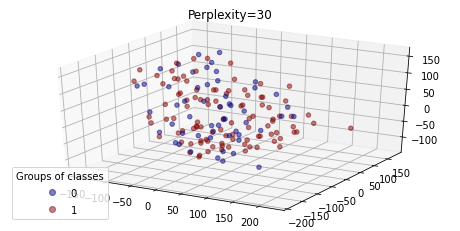

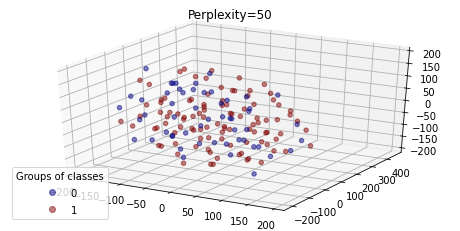

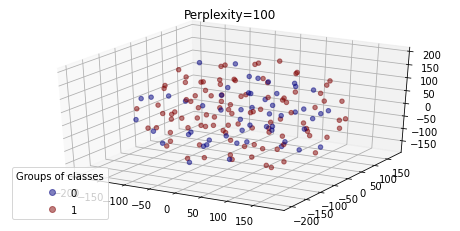

In [110]:
best_features_selected = features_filtered_final[results['selectedFeatures']].values

perplexities = [5, 10, 30, 50, 100]

cmap_classes = plt.cm.get_cmap('jet',2)
for i, perplexity in enumerate(perplexities):
    fig = plt.figure(figsize=plt.figaspect(0.5))  
    ax = fig.add_subplot(111, projection='3d')
   
    tsne = TSNE(n_components=3, init='random',random_state=0, perplexity=perplexity)
    pca_tsne_features_perp = tsne.fit_transform(best_features_selected)
    ax.set_title("Perplexity=%d" % perplexity)
    scatter = ax.scatter3D(pca_tsne_features_perp[:,0], pca_tsne_features_perp[:,1], pca_tsne_features_perp[:,2],
                           cmap=cmap_classes, c=df['class'],alpha=0.5)
    ax.legend(*scatter.legend_elements(),loc="lower left", title="Groups of classes")

    plt.show()

No se observa una buena agrupación con tSNE

#### Curvas ROC y PR 

Graficamos ambas curvas. Elegimos el umbral que optimice el score F1

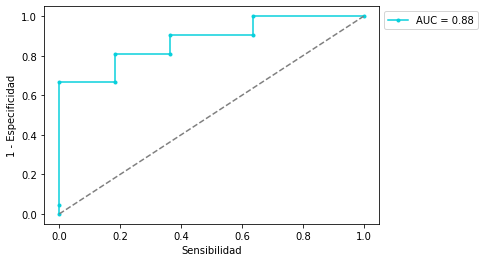

In [111]:
#Gráfico de la curva ROC y obtención del AUC
from sklearn import metrics 

y_probs = results['testProbas']
clase = 0

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)
auc = metrics.roc_auc_score(y_test, y_probs)

ns_probs = [0 for _ in range(len(y_test))]

plt.plot(fpr, tpr, marker='.', label='AUC = %0.2f' %(auc), color = '#07D0DC')
plt.plot(fpr, fpr, linestyle = '--', color = 'gray')
plt.xlabel('Sensibilidad')
plt.ylabel('1 - Especificidad')
plt.legend(bbox_to_anchor=(1,1))


In [113]:
len(set(results['testProbas']))

32

Notamos que la curva ROC tiene saltos abruptos. 

In [114]:
thresholds

array([1.93463463, 0.93463463, 0.70912698, 0.68417845, 0.578     ,
       0.44374218, 0.38303993, 0.35714286, 0.345     , 0.27094017])

Best F1 had recall=0.9047619047619048 and precision=0.8260869565217391
Max F1 score: 0.8636363636363631


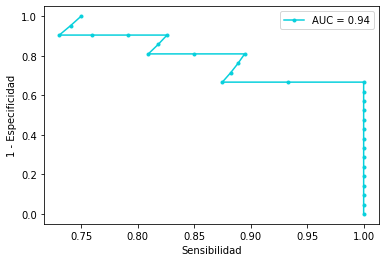

In [121]:
precision, recall, ths_prec_recall = precision_recall_curve(y_test, y_probs)
auc_pr = metrics.auc(recall, precision)
plt.plot(precision, recall, marker='.', label='AUC = %0.2f' %(auc_pr), color = '#07D0DC')
plt.xlabel('Sensibilidad')
plt.ylabel('1 - Especificidad')
plt.legend(bbox_to_anchor=(1,1))
f1_scores = 2 * recall * precision / (recall + precision + 1e-15)


maxf1threhsold = ths_prec_recall[np.argmax(f1_scores)]
maxrecall_valid = recall[np.argmax(f1_scores)]
maxprecision_valid= precision[np.argmax(f1_scores)]
print(f'Best F1 had recall={maxrecall_valid} and precision={maxprecision_valid}')
print('Max F1 score: {}'.format(f1_scores.max()))

In [122]:
maxf1threhsold

0.38303993303993306

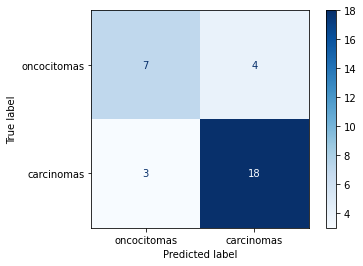

In [128]:
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_probs>maxf1threhsold)

display_labels = ['oncocitomas','carcinomas']


disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=display_labels)
disp.plot(cmap='Blues')

El gran problema en este caso serían los 3 carcinomas clasificados como oncocitomas, ya que se podría cambiar la conducta quirúrgica (no operar). En cambio los oncocitomas clasificados como carcinomas, con la conducta quirúrgica estándar actual hubiesen sido operados igualmente. Además, optimizar el umbral en testeo puede mostrar un sobreajuste indirectamente.

#### Optimización de umbral con conjunto de entrenamiento

In [131]:
preprocess = pipeline.split('_')[0]
selector = pipeline.split('_')[1]
model = pipeline.split('_')[2]

print('\n--------------------------------------\n')
print(pipeline)
print('\n--------------------------------------\n')

trainedPipeline = pickle.load(open(drive_dir+'gridSearchs/'+pipeline,'rb'))

selector_ = trainedPipeline[0]
search = trainedPipeline[1]



--------------------------------------

minMaxScaling_wrapper-LR-bw_RF

--------------------------------------



Buscaremos maximizar el valor predictivo negativo, pero implementado como maximizar la precision pero considerando los oncocitomas como 1

In [132]:
x_ = preProcessedFeatures[preprocess][idx_train,:]  #Normalizacion
x_ = selector_.transform(x_)
train_preds_proba = search.best_estimator_.predict_proba(x_)[:,0]
y = [not bool(f)  for f in df.loc[idx_train,'class'].values]

Best F1 had recall=0.9302325581395349 and precision=0.8888888888888888
Max F1 score: 0.9090909090909086


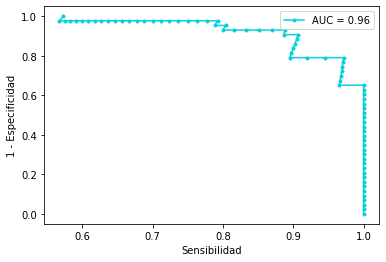

In [133]:
precision, recall, ths_prec_recall = precision_recall_curve(y, train_preds_proba)
auc_pr = metrics.auc(recall, precision)
plt.plot(precision, recall, marker='.', label='AUC = %0.2f' %(auc_pr), color = '#07D0DC')
plt.xlabel('Sensibilidad')
plt.ylabel('1 - Especificidad')
plt.legend(bbox_to_anchor=(1,1))
f1_scores = 2 * recall * precision / (recall + precision + 1e-15)


maxf1threhsold = ths_prec_recall[np.argmax(f1_scores)]
maxrecall_valid = recall[np.argmax(f1_scores)]
maxprecision_valid= precision[np.argmax(f1_scores)]
print(f'Best F1 had recall={maxrecall_valid} and precision={maxprecision_valid}')
print('Max F1 score: {}'.format(f1_scores.max()))

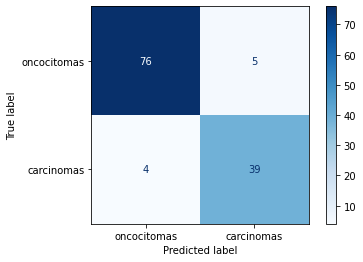

In [145]:
cm = confusion_matrix(y, train_preds_proba>maxf1threhsold) #Usamos el signo menor, porque lo que queremos es que la prediccion sea oncocitoma cuando la probabilidad de carcinoma 

display_labels = ['oncocitomas','carcinomas']


disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=display_labels)
disp.plot(cmap='Blues')

In [134]:
maxf1threhsold  

0.48561711361711357

Cuando la probabilidad de oncocitoma es mayor que maxf1threhsold, decimos oncocitoma. Es lo mismo que decir que cuando la probabilidad de carcinoma es menor que 1 - maxf1threhsold, decimos carcinoma

Evaluamos en testeo:

In [142]:
binarypreds = [not bool(f)  for f in  (1-y_probs)>maxf1threhsold]

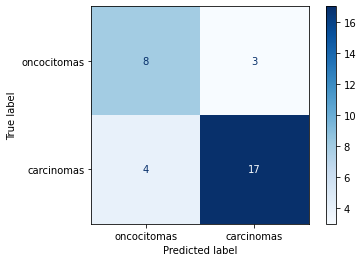

In [143]:
cm = confusion_matrix(y_test, binarypreds) #Usamos el signo menor, porque lo que queremos es que la prediccion sea oncocitoma cuando la probabilidad de carcinoma 

display_labels = ['oncocitomas','carcinomas']


disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=display_labels)
disp.plot(cmap='Blues')

No se observa el desempeño esperado (evitar falsos negativos). Puede estar relacionado a las diferencias entre las distribuciones de entrenamiento y de test

### Análisis de atributos de mayor importancia

In [152]:
impDF = pd.DataFrame({'Name':results['selectedFeatures'],'Importance':search.best_estimator_.feature_importances_})
impDF[impDF.Importance!=0].sort_values("Importance",ascending=False)


,Name,Importance
0,original_firstorder_Median,0.117785
53,wavelet-LLL_firstorder_Minimum,0.069594
64,wavelet-LLL_glcm_JointAverage,0.068859
46,wavelet-LLL_firstorder_10Percentile,0.064872
5,wavelet-LLH_firstorder_Skewness,0.063430
65,wavelet-LLL_gldm_DependenceEntropy,0.046890
28,wavelet-HHL_gldm_GrayLevelNonUniformity,0.044551
18,wavelet-HLH_firstorder_Median,0.043730
44,wavelet-HHH_gldm_LargeDependenceLowGrayLevelEm...,0.039515
11,wavelet-HLL_firstorder_RootMeanSquared,0.035168


In [154]:
print(impDF[impDF.Importance!=0].shape)

(43, 2)


Vemos que el atributo con mayor peso para el bosque aleatorio es la mediana de los valores de gris de la imagen original. Le siguen atributos de la imagen filtrada con tres decomposicione pasabajos de wavelets (wavelet-LLL). 
Hay 43 atributos que realmente son utilizados (feature importance distinta de 0). La gran mayoría son de wavelets

## Conclusión 

Como conclusión, encontramos un modelo que presenta un desempeño satisfactorio en el dataset de testeo, con altos valores de área bajo la curva. Como trabajo a futuro queda la búsqueda de un punto de operación que ponga enfásis en reducir los falsos negativos (carcinomas clasificados como oncocitomas), ya que es el error de mayor costo para el paciente. 

